In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [73]:
pip install yahoo_fin

Note: you may need to restart the kernel to use updated packages.


In [74]:
from yahoo_fin.stock_info import get_data
#importing yahoo api for fetching data

In [76]:
amazon = get_data("amzn", start_date="12/04/2009", end_date="12/04/2019", index_as_date = True, interval="1mo")
#testing to get amazon's data

In [93]:
apple = get_data("aapl", start_date="01/01/2010", end_date="01/10/2023", index_as_date = True, interval="1d")
apple.head()
#For testing purpose we'll be working on apple's data

,open,high,low,close,adjclose,volume,ticker
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.487534,493729600,AAPL
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.498751,601904800,AAPL
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.395380,552160000,AAPL
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.383555,477131200,AAPL
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.425994,447610800,AAPL


In [94]:
apple = apple.reset_index()
#We are reseting the data part as index for our data. cause we don't require date for our model

In [95]:
apple = apple.drop(['index','adjclose','ticker'],axis = 1)
apple.head()

#Here I removed columns which is not for my use.

,open,high,low,close,volume
0,7.622500,7.660714,7.585000,7.643214,493729600
1,7.664286,7.699643,7.616071,7.656429,601904800
2,7.656429,7.686786,7.526786,7.534643,552160000
3,7.562500,7.571429,7.466071,7.520714,477131200
4,7.510714,7.571429,7.466429,7.570714,447610800


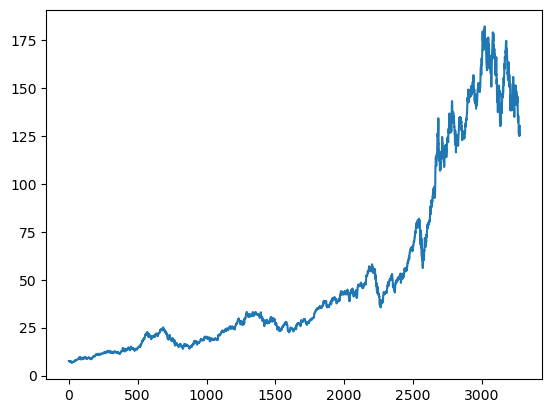

In [96]:
plt.plot(apple.close)
#Here we plotted the close price in a graphical manner.

In [97]:
ma100 = apple.close.rolling(100).mean()
#We calculated moving average by taking the last 100 records and then we found out the mean of that.

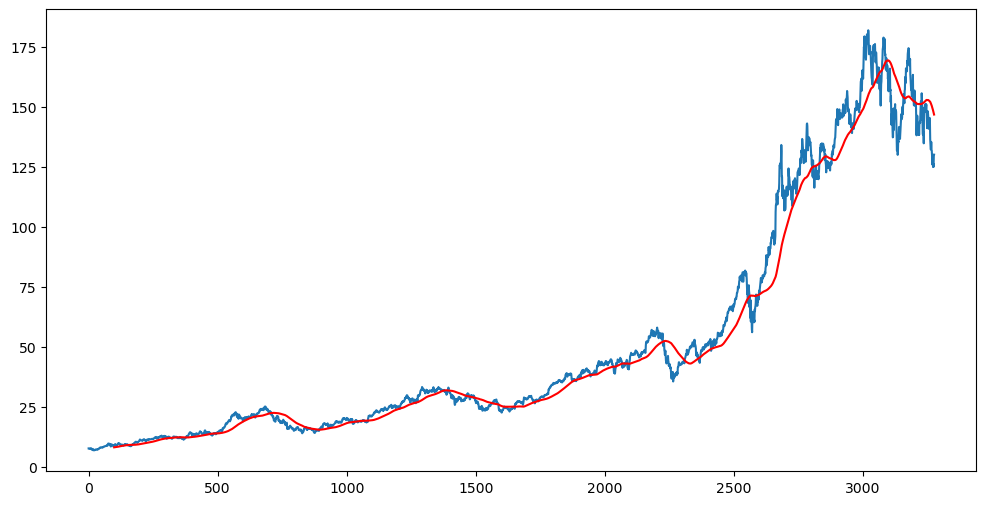

In [98]:
plt.figure(figsize = (12,6))
plt.plot(apple.close)
plt.plot(ma100,'r')

In [99]:
ma200 = apple.close.rolling(200).mean()
#We calculated moving average by taking the last 200 records and then we found out the mean of that.

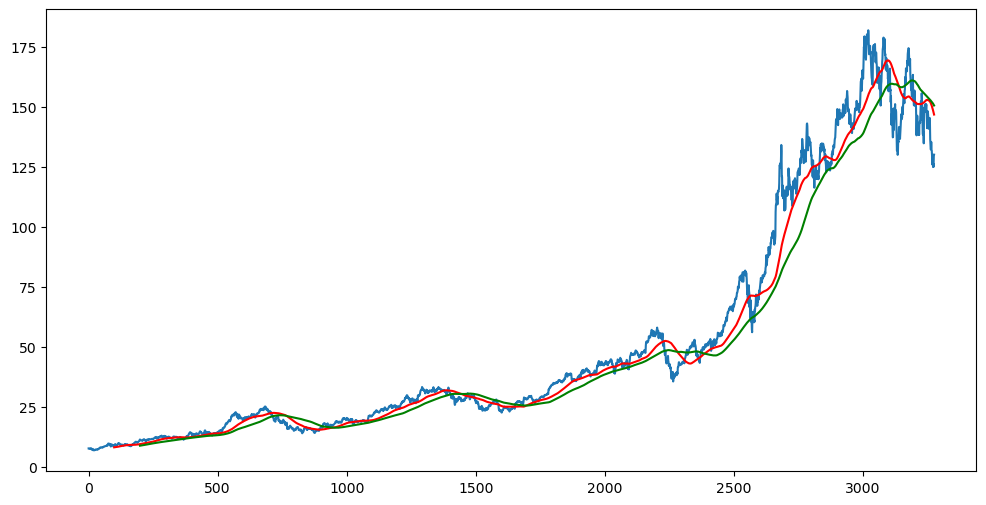

In [100]:
plt.figure(figsize = (12,6))
plt.plot(apple.close)
plt.plot(ma100,'r')
plt.plot(ma200,'g')
#Plotted both the graphs together.
#We can see green line is moving 200
#and red line is moving 100.
#Whenever we see MA200 has crossed MA100, the stock closing price goes high.
#Inverse is also true, MA100 goes up, stock closing prices goes down.

In [101]:
#Splitting Data into Training and Testing
#For data prediction we do this splitting.
#For training purpose. We took 70% of the data and for
#testing purpose we took the last 30%.
import pandas as pd
print(apple.shape)

dtrain = pd.DataFrame(apple['close'][0:int(len(apple)*0.70)])
dtest = pd.DataFrame(apple['close'][int(len(apple)*0.70):int(len(apple))])

print(dtrain.shape)
print(dtest.shape)

(3277, 5)
(2293, 1)
(984, 1)


In [102]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
#Then for better accuracy we scaled down the entire data between the values
#(0,1) for providing it to LSTM model.

In [103]:
data_train_array = scaler.fit_transform(dtrain)
data_train_array

array([[0.01533047],
       [0.01558878],
       [0.01320823],
       ...,
       [0.69868196],
       [0.69389287],
       [0.70102759]])

In [104]:
data_train_array.shape

(2293, 1)

In [110]:
#We applied simple time series analogy
#The value of the stock at the 100th day will depend on how it is been in the last 100 days.
#The previous 100 days value will become our x_train and all the predicted values i.e 101th data
#will be considered for y_train
x_train = []
y_train = []
for i in range(100,data_train_array.shape[0]):
    x_train.append(data_train_array[i-100:i])
    y_train.append(data_train_array[i,0])

x_train,y_train = np.array(x_train), np.array(y_train)
#We converted our x_train and y_train into numpy arrays

In [111]:
x_train.shape

(2193, 100, 1)

In [107]:
#ML Model

In [28]:
pip install tensorflow
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [6]:
from keras.layers import Dense,Dropout,LSTM
from keras.models import Sequential

In [112]:
model = Sequential()
model.add(LSTM(units=50,activation = 'relu',
               return_sequences = True,
               input_shape = (x_train.shape[1],1)))
model.add(Dropout(0.2))
#in this section, input shape defines that we are taking only one column and only
#column values from x_train value, if we want close,open and other
#sections as well then we need to write number more than 1.
model.add(LSTM(units=60,activation = 'relu',return_sequences = True))
model.add(Dropout(0.3))
model.add(LSTM(units=80,activation = 'relu',return_sequences = True))
model.add(Dropout(0.4))
model.add(LSTM(units=120,activation = 'relu'))
model.add(Dropout(0.5))
# Last model to predict the closing price.
model.add(Dense(units=1))


#In the section, we created four layers for our LSTM model.

In [31]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 30, 30)            3840      
                                                                 
 dropout_4 (Dropout)         (None, 30, 30)            0         
                                                                 
 lstm_5 (LSTM)               (None, 30, 40)            11360     
                                                                 
 dropout_5 (Dropout)         (None, 30, 40)            0         
                                                                 
 lstm_6 (LSTM)               (None, 30, 70)            31080     
                                                                 
 dropout_6 (Dropout)         (None, 30, 70)            0         
                                                                 
 lstm_7 (LSTM)               (None, 100)              

In [113]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(x_train, y_train, epochs = 50)

#We compiled our model using ADAM optimizer. We kept our loss
#as mean squared error. 

#Other types of crosses are:
# 1. Cross Categorical Entropy
# 2. Binary cross Entropy 
# But both of them are for classification purpose.

Epoch 1/50
69/69 [==============================] - 9s 110ms/step - loss: 0.0360
Epoch 2/50
69/69 [==============================] - 8s 111ms/step - loss: 0.0074
Epoch 3/50
69/69 [==============================] - 8s 116ms/step - loss: 0.0063
Epoch 4/50
69/69 [==============================] - 8s 119ms/step - loss: 0.0058
Epoch 5/50
69/69 [==============================] - 8s 123ms/step - loss: 0.0055
Epoch 6/50
69/69 [==============================] - 8s 117ms/step - loss: 0.0050
Epoch 7/50
69/69 [==============================] - 8s 117ms/step - loss: 0.0056
Epoch 8/50
69/69 [==============================] - 8s 116ms/step - loss: 0.0043
Epoch 9/50
69/69 [==============================] - 8s 118ms/step - loss: 0.0043
Epoch 10/50
69/69 [==============================] - 8s 114ms/step - loss: 0.0040
Epoch 11/50
69/69 [==============================] - 8s 118ms/step - loss: 0.0040
Epoch 12/50
69/69 [==============================] - 8s 118ms/step - loss: 0.0034
Epoch 13/50
69/69 [======

In [114]:
model.save('keras_model.h5')

/Users/Prathmesh/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [115]:
dtest.head()

,close
2293,42.544998
2294,42.700001
2295,42.605000
2296,42.732498
2297,43.007500


In [119]:
past_100_days = dtrain.tail(100)

In [120]:
final_df = past_100_days.append(dtest, ignore_index = True)

/var/folders/6k/zhwh5gdx3b38036kx__95sxc0000gn/T/ipykernel_9663/142916442.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = past_100_days.append(dtest, ignore_index = True)


In [121]:
final_df

,close
0,54.592499
1,55.007500
2,54.415001
3,55.197498
4,55.547501
...,...
1079,125.070000
1080,126.360001
1081,125.019997
1082,129.619995


In [150]:
input_data = scaler.fit_transform(final_df)
input_data

array([[0.13003328],
       [0.13286677],
       [0.12882138],
       ...,
       [0.61089016],
       [0.64229751],
       [0.64591617]])

In [138]:
x_test = []
y_test = []
for i in range(100,input_data.shape[0]):
    x_test.append(input_data[i-100:i])
    y_test.append(input_data[i,0])

In [139]:
x_test,y_test = np.array(x_test), np.array(y_test)
y_test.shape

(984,)

In [140]:
#Making predictions

y_predicted = model.predict(x_test)

31/31 [==============================] - 1s 29ms/step


In [141]:
y_predicted.shape

(984, 1)

In [142]:
scaler.scale_

array([0.00682769])

In [144]:
scale_factor = 1/0.00682769
y_predicted = y_predicted * scale_factor
y_test = y_test * scale_factor

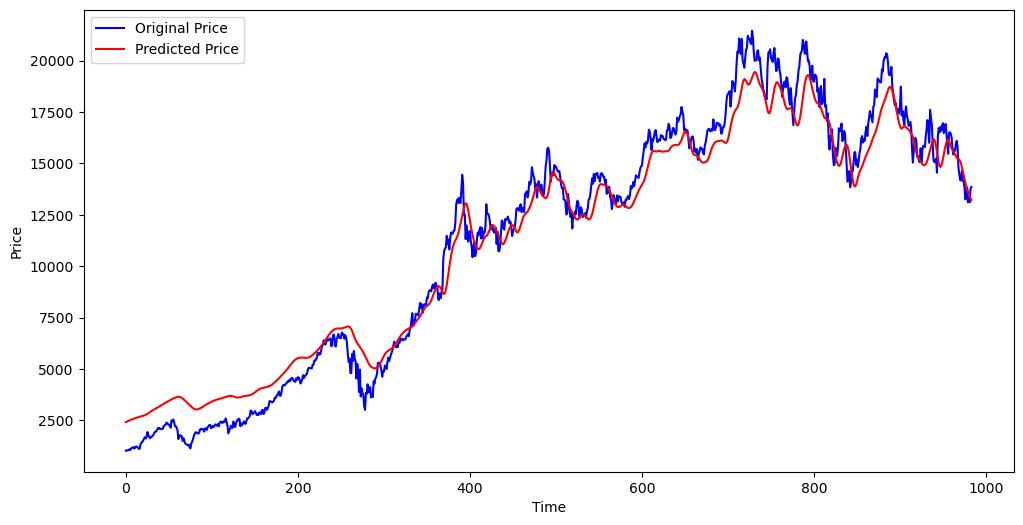

In [145]:
plt.figure(figsize = (12,6))
plt.plot(y_test, 'b', label = 'Original Price')
plt.plot(y_predicted, 'r', label = 'Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()           